In [126]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/mklukas/workspace/htm_projects/k-sparse_autoencoder/src")
from lateral_k_sparse_autoencoder import LateralKSparseAE

params = {
    "num_inputs": 28**2,
    "num_outputs": 200,
    "code_weight": 10,
    "learning_rate": 0.1,
    "beta": 0.001,
    "enforce_binary_output": False,
    "enable_boosting"      : True,
    "enforce_code_weight"  : True
}

sp = LateralKSparseAE(**params)
print sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Lateral k-sparse autoencoder:**
------------------
Number of inputs (m):	 784
Number of outputs (n):	 200
Code weight (k):	 10
Sparsity (k/n):		 0.05
Beta:			 0.001
Learning rate:		 0.1
Boosting:		 True
Min/Max weights :	 -4.26  |  +4.68
------------------


0
1
2


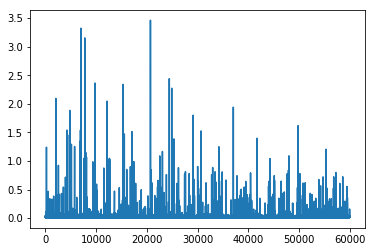

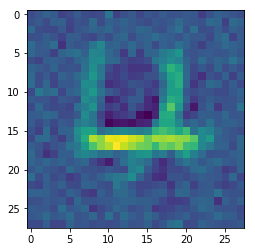

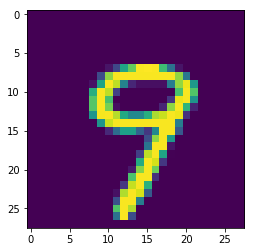

In [127]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier

mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


d = 60000
for i in range(3):
    print i
    perm = np.random.permutation(len(X_train))
    Y, E, L = sp.fit(X_train[perm][:d])

plt.plot(L)
plt.show()
plt.imshow(sp.weights[1].reshape(28,28))
plt.show()
plt.imshow(X_train[perm][0].reshape(28,28))


In [128]:

W = sp.weights

print "Min/mac weight", np.amin(W), np.amax(W)
print "Min/max output", np.amin(Y[-1000:]), np.amax(Y[-1000:])
print "Min/max energy", np.amin(E[-1000:]), np.amax(E[-1000:])


def normalize(x):
    x = x - np.amin(x)
    x = x/np.amax(x)
    return x

Min/mac weight -0.632140419079 0.633905230298
Min/max output 0.0 0.0
Min/max energy -8.30090921846 6.36779309427


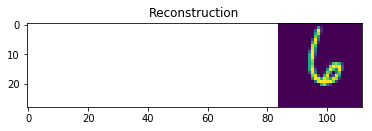

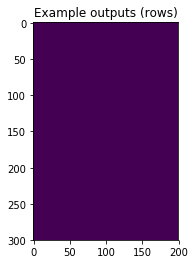

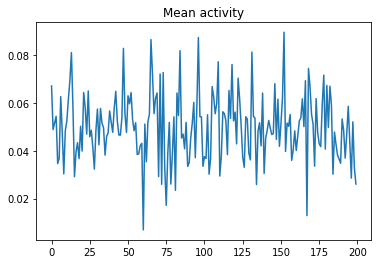

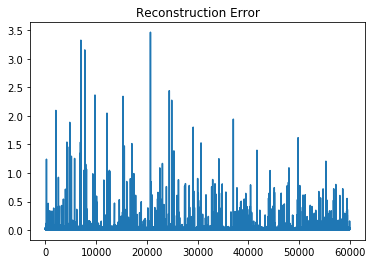

10
20
(280, 560)


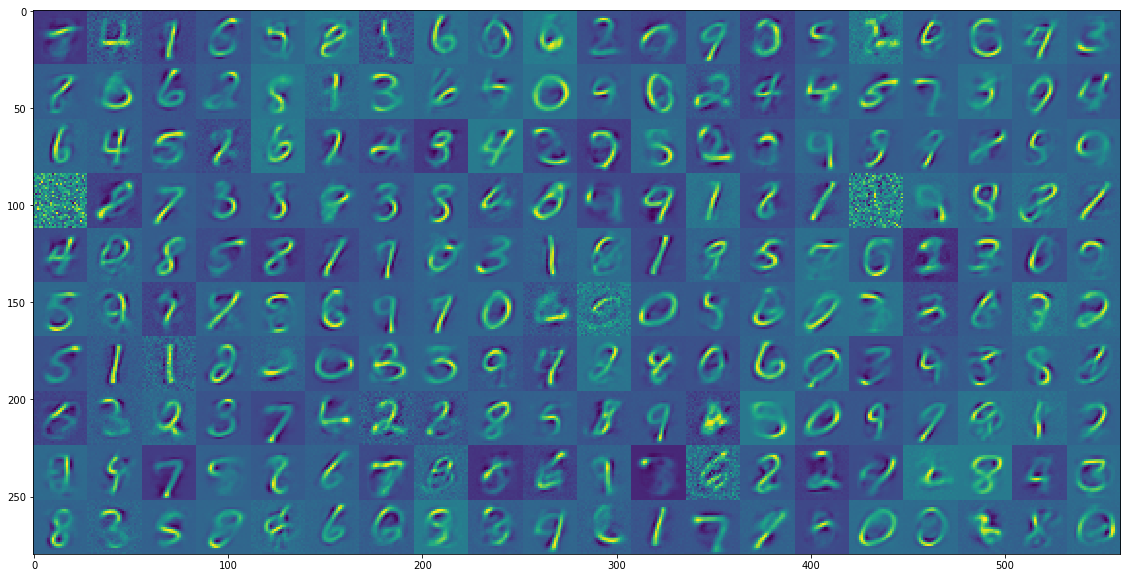

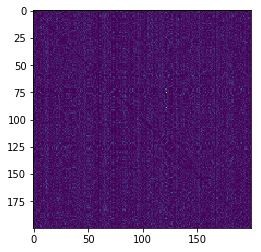

In [129]:
from scipy.special import expit as sigmoid
W = sp.weights
k = sp.code_weight
t=-1

x_hat = np.dot(W.T, Y[t]).reshape(28,28)
x_hat_sig = sigmoid(0.2*x_hat)
x_hat_e = np.dot(W.T, E[t]*Y[t]).reshape(28,28)
x = X_train[perm][t].reshape(28,28)

x = normalize(x)
x_hat = normalize(x_hat)
x_hat_sig = normalize(x_hat_sig)
x_hat_e = normalize(x_hat_e)
plt.title("Reconstruction")

plt.imshow(np.concatenate([x_hat, x_hat_sig, x_hat_e, x], axis=1))
plt.show()

plt.title("Example outputs (rows)")
plt.imshow(Y[:300])
plt.show()

plt.title("Mean activity")
plt.plot(sp.mean_activity)
plt.show()

plt.title("Reconstruction Error")
plt.plot(L[:])
plt.show()

f = 10
n = sp.num_outputs
W = sp.weights
img_matrix = [[ W[i*n//f + j].reshape(28,28) for j in range(n//f) ]    for i in range(f)]

img_matrix = [[ img - np.amin(img) for img in row ] for row in img_matrix ]
img_matrix = [[ img/np.amax(img) for img in row ] for row in img_matrix ]

print len(img_matrix)
print len(img_matrix[0])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(100,10))
print img.shape
plt.imshow(img)
plt.show()
plt.imshow(sp.lateralConnections)


## 

In [132]:
# Y = sp.encode(X[:10])
# plt.imshow(Y)
# print np.sum(Y, axis=1)
L = sp.lateralConnections
print np.amax(L)

per = np.random.permutation(len(X_test))


0.0977735740709


22.3510915346


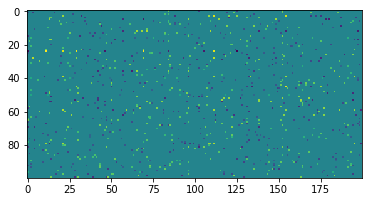

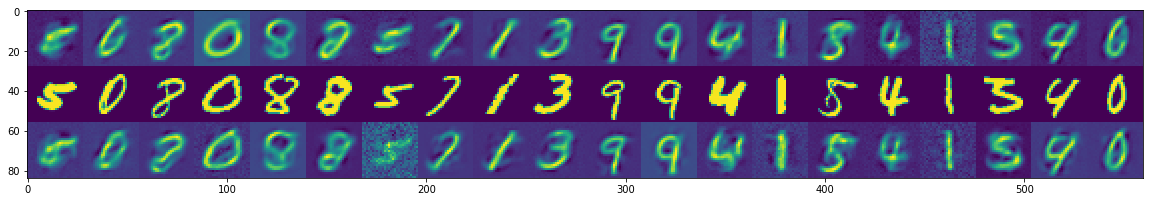

In [133]:

T = 100
Y_test = sp.encode(X_test[per][:T], with_lateral=False, enforce_binary_output=False)
# Y_test = sp._encode_binary(X_test[per][:T], with_boosting=False)
Y_test_ = sp.encode(X_test[per][:T], with_lateral=True, enforce_binary_output=False)

plt.imshow( Y_test - Y_test_ )
# X_hat =  sigmoid(np.dot(Y_test, sp.weights))
X_hat =  np.dot(Y_test, sp.weights)

# X_hat_ = sigmoid( np.dot(Y_test_, sp.weights))
X_hat_ =  np.dot(Y_test_, sp.weights)

print np.sum((X_hat - X_test[per][:T])**2)/T
img_matrix = []
for i in range(20):
    x = normalize(X_test[per][i])
    x_hat = normalize(X_hat[i])
    x_hat_ = normalize(X_hat_[i])
    
    img_matrix.append([ x_hat.reshape((28,28)).T, x.reshape((28,28)).T, x_hat_.reshape((28,28)).T])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(20,10))
plt.imshow(img.T)